<div class="alert alert-block alert-warning"><b>PLEASE READ BEFORE:</b><br>
    1. This notebook is a quick walkthrough of the major discorveries I have found in the zillow clustering project.<br>
    2. Hence, it doesn't contain all the work I have done.<br> 
    3. The complete work could be found in the wrangle_zillow.py, explore_zillow.ipynb, cluster_zillow.ipynb and model_zillow.ipynb.<br>
    4. Since this notebook is also used for presentation, the slides are styled with block quoting and in Italic text.</div>

In [1]:
# Set up the environment

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.formula.api import ols
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.linear_model import LinearRegression, LassoLars
from sklearn.preprocessing import PolynomialFeatures
from sklearn.cluster import KMeans

import acquire, summarize, prepare, wrangle_zillow, features, model

from IPython.display import Image

> ## *Exploring the Drivers of the Logerror in the Zestimate*
> ### *Presented by: Yongliang Shi*
> ### *Date: Oct 21, 2020*

> ## *Goal: to uncover what the drivers of the error in the zestimate are*
  - ### *Step 1: Explore the Target Variable Logerror*
  - ### *Step 2: Clustering Logerror*
  - ### *Step 3: Modeling and Evalution*

<div class="alert alert-block alert-warning"><b>PLEASE READ.</b><br>
    1. Zillow dataset is wrangled in two different ways: one is for exploration and the other is for modeling.<br>
    2. Below are the summary of the data preparation.<br>
    3. If you are interested in the original codes, please find them in wrangle_zillow.py.</div>

<div class="alert alert-block alert-info"><b>Summary of Data Preparation for Exporation:</b><br>
    1. Zillow dataset is aqcuired from codeup clound by quering the properties in 2017 with no missing data in latitude and longitude.<br>
    2. Keep the last transaction for each property.<br>
    3. Keep the single unit properies only (260, 261, 262, 279).<br>
    4. Drop columns and rows with more than 40% of missing values.<br>
    5. Drop reductant and object columns: id', 'id.1', propertyzoningdesc', heatingorsystemtypeid', 'calculatedbathnbr'.<br>
    6. Fill 'None' for the null values in column heatingorsystemdesc.<br>
    7. Split the data to train, validate and test.<br>
    8. Impute the categorical variables with mode.<br>
    9. Impute the numeric variables with median.</div>    

<div class="alert alert-block alert-info"><b>Summary of Data Preparation for Modeling:</b><br>
    1. Zillow dataset is aqcuired from codeup clound by quering the properties in 2017 with no missing data in latitude and longitude.<br>
    2. Keep the last transaction for each property.<br>
    3. Keep the single unit properies only (260, 261, 262, 279).<br>
    4. Drop columns and rows with more than 40% of missing values.<br>
    5. Drop reductant and object columns: id', 'id.1', propertyzoningdesc', heatingorsystemtypeid', 'propertylandusetypeid', 'unitcnt', 'assessmentyear', 'transactiondate', 'propertylandusedesc','regionidcounty', 'regionidcity', 'regionidzip', 'rawcensustractandblock', 'censustractandblock', 'propertycountylandusecode', 'heatingorsystemdesc', 'calculatedbathnbr'.<br>
    6. Map fips to the county names and then encode them to dummy variables.<br>
    7. Create a new categorical variable 'error_type'.<br>
    8. Split the data to train, validate and test.<br>
    9. Impute the categorical variables with mode.<br>
    10. Impute the numeric variables with median.</div>    

In [2]:
# Acquire the zillow dataset
zillow = acquire.get_zillow_clustering()

# Wrangle the zillow dataset for exploration
train, validate, test = wrangle_zillow.wrangle_zillow_clustering(zillow)

# Map fips to county names
train.fips = train.apply(lambda i: wrangle_zillow.add_county_column(i), axis=1)

# Create a variable to hold the target variable
target_var = train.logerror

> ## *Explore Target Variable - What does the logerror look like?* 

In [3]:
# Print the descriptive statistics of the target variable logerror

percentiles = [0.1, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7, 0.75, 0.8, 0.9]
train.logerror.describe(percentiles).round(3)

count    31028.000
mean         0.020
std          0.178
min         -4.655
10%         -0.071
20%         -0.035
25%         -0.024
30%         -0.016
40%         -0.004
50%          0.007
60%          0.018
70%          0.031
75%          0.041
80%          0.053
90%          0.105
max          3.395
Name: logerror, dtype: float64

<div class="alert alert-block alert-info"><b>Takeaways:</b><br>
    1. The logerror ranges from -4.7 to 3.4.<br>
    2. The mean is 0.02 and the median is 0.007.<br>
    3. Majority of the data (about 80%) falls in the range from -0.1 to 0.1.</div>

> ## *Explore Target Varibale logerror - What does the number mean?* 
  - ### *logerror = $\log(zestimate) - log(saleprice)$  =  $\log(zestimate/saleprice)$*
      - ### *if logerror = -4.655(min) --> zestimate / sale price = 0.00002*
      - ### *if logerror = 0.007(50%) --> zestimate / sale price = 1.016*
      - ### *if logerror = 3.395(max) --> zestimate / sale price = 2483*

[Text(0.5, 0, '')]

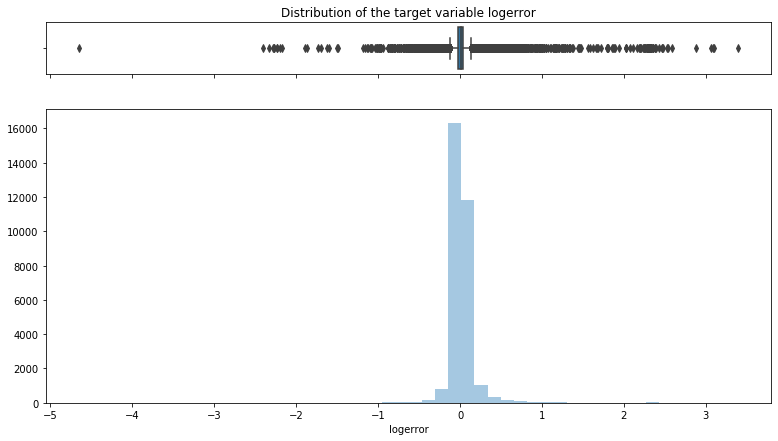

In [4]:
# Visualize the logerror distribution by boxplot at the top and histogram at the bottom.

# Cut the window into 2 parts
fig, (ax_box, ax_hist) = plt.subplots(2, sharex=True, figsize=(13,7),  
                                      gridspec_kw={"height_ratios": (0.15, 0.85)})

# Add the graphs in each part
sns.boxplot(target_var, ax=ax_box)
sns.distplot(target_var, kde=False, ax=ax_hist)

# Add title
ax_box.set_title('Distribution of the target variable logerror')

# Remove x axis name for the boxplot
ax_box.set(xlabel='')

# Finally, the picture is saved as logerror_dist.png for the purpose of presentation.

<div class="alert alert-block alert-info"><b>Takeaways:</b><br>
    1. Most of the log errors are around zero.<br>
    2. Plenty of outliers exsis, as shown in the boxplot.<br>
    3. The shape of the distribution looks normal.</div>

> ## *Explore Target Varibale logerror* 
  - ### *logerror = $\log(zestimate) - log(saleprice)$  =  $\log(zestimate/saleprice)$*
      - ### *Sale price is not available, but...*
      - ### *Assessed value: taxvaluedollarcnt, which has been modeled in the previous regression project.*

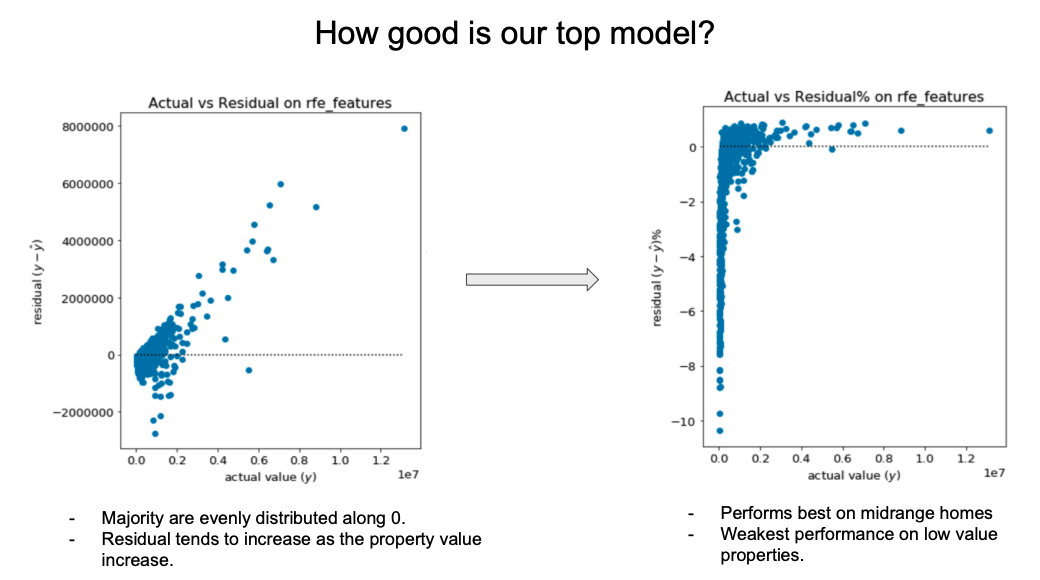

In [5]:
# Load residual analysis result from regression project

Image(filename = "regression_model_performance.png", width = 750, height = 500)

<div class="alert alert-block alert-info"><b>Takeaways:</b><br> 
    1. When I built the regression models, the most important takeaway from that is I found the model error, which is represented by residuals or residual percentage, is related to tax value dollar cnt.<br>
    2. It is worth noticing that the largest errors come from the properties with low values.</div>

> ## *Does the statement below stand true?*
> ### *- Our target variable logerror is related to the assessed value?* 

Text(0.5, 1.0, 'Distribtion of logerror against log(assessed values)')

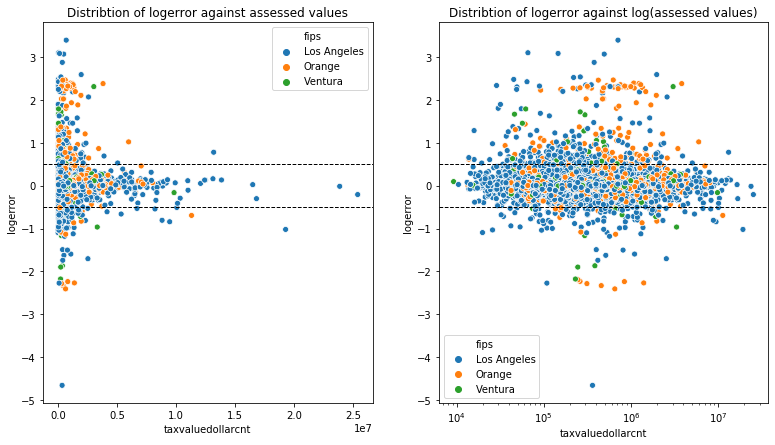

In [6]:
# Plot distribution of logerror against assessed value (taxvaluedollarcnt)
plt.figure(figsize=(13,7))

# against taxvaluedollarcnt
plt.subplot(121)
sns.scatterplot(data=train, x='taxvaluedollarcnt', y='logerror', hue='fips')
plt.axhline(0.5, color='k', linestyle='dashed', linewidth=1)
plt.axhline(-0.5, color='k', linestyle='dashed', linewidth=1)
plt.title('Distribtion of logerror against assessed values')

# against log(taxvaluedollarcnt)
plt.subplot(122)
ax = sns.scatterplot(data=train, x='taxvaluedollarcnt', y='logerror', hue='fips')
ax.set(xscale='log')
plt.axhline(0.5, color='k', linestyle='dashed', linewidth=1)
plt.axhline(-0.5, color='k', linestyle='dashed', linewidth=1)
plt.title('Distribtion of logerror against log(assessed values)')

# Finally, the picture is saved as logerror_taxvalue.png for the purpose of presentation.

<div class="alert alert-block alert-info"><b>Takeaways: similar pattern is observed</b><br> 
    1. On the left: The log error tends to increase in both ways, whether positive or negative as the property value drops.<br>
    2. On the right: because the error is log-transformed, so I log-transformed the taxvaluedollarcnt as well. When I first saw it, it looks like a football to me. If I draw the lines, I can roughly divide the football into three parts.<br> 
    3. This is the first time I realized that I may need to cluster the logerror.</div> 

Text(0.5, 1.0, 'Distribution of logerror again finished square feet')

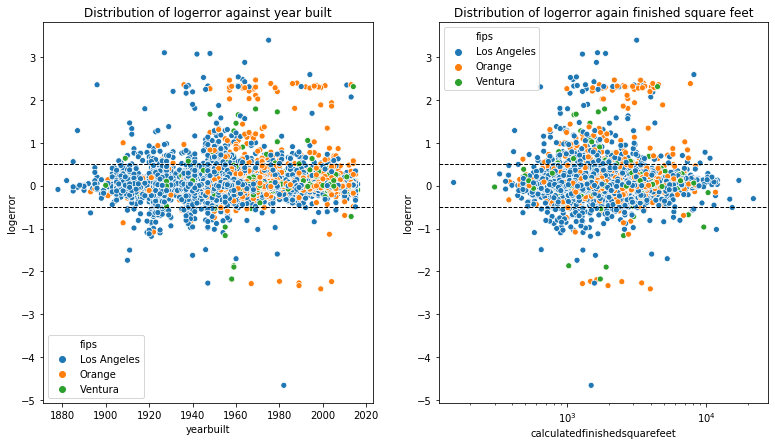

In [7]:
# Plot the distribution of log error against the yearbuilt and calculatedfinishedsquarefeet

plt.figure(figsize=(13,7))

# Against yearbuild
plt.subplot(121)
ax1 = sns.scatterplot(data=train, x='yearbuilt', y='logerror', hue='fips')
plt.axhline(0.5, color='k', linestyle='dashed', linewidth=1)
plt.axhline(-0.5, color='k', linestyle='dashed', linewidth=1)
plt.title('Distribution of logerror against year built')

# Against calculatedfinishedsquarefeet
plt.subplot(122)
ax2 = sns.scatterplot(data=train, x='calculatedfinishedsquarefeet', y='logerror', hue='fips')
ax2.set(xscale='log')
plt.axhline(0.5, color='k', linestyle='dashed', linewidth=1)
plt.axhline(-0.5, color='k', linestyle='dashed', linewidth=1)
plt.title('Distribution of logerror again finished square feet')

# Finally, the picture is saved as logerror_year_square.png for the purpose of presentation.

<div class="alert alert-block alert-info"><b>Takeaways: similar pattern shows up.</b><br></div>

Text(0.5, 1.0, 'Distribution of logerror against latitude')

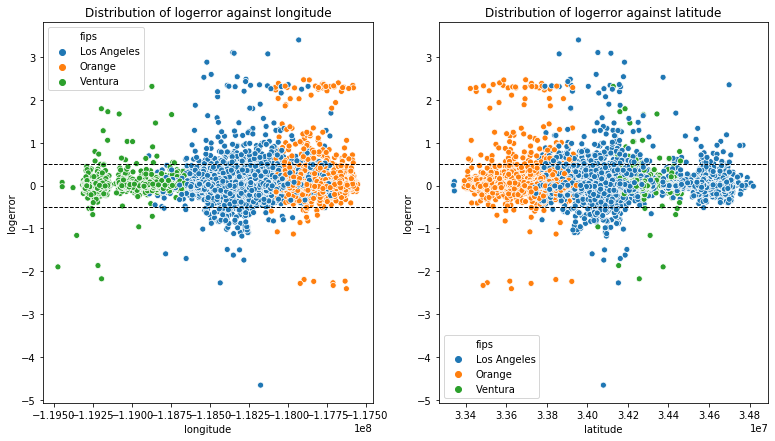

In [8]:
# Plot the distribution of logerror against longitude and latitude
plt.figure(figsize=(13,7))

# Against longitude
plt.subplot(121)
sns.scatterplot(data=train, x='longitude', y='logerror', hue='fips')
plt.axhline(0.5, color='k', linestyle='dashed', linewidth=1)
plt.axhline(-0.5, color='k', linestyle='dashed', linewidth=1)
plt.title('Distribution of logerror against longitude')

# Against latitude
plt.subplot(122)
sns.scatterplot(data=train, x='latitude', y='logerror', hue='fips')
plt.axhline(0.5, color='k', linestyle='dashed', linewidth=1)
plt.axhline(-0.5, color='k', linestyle='dashed', linewidth=1)
plt.title('Distribution of logerror against latitude')

# Finally, the picture is saved as logerror_long_lat.png for the purpose of presentation.

<div class="alert alert-block alert-info"><b>Takeaways: As I further explored, a similar pattern keeps repeating itself. All of this let me decide to chase it down: how about clustering the zillow dataset on the logerror?</b></div>

> ## *What if Clustering on logerror?*

> ## *What if Clustering on logerror?*
> - ### *Group 1 features: logtaxvaluedollarcnt, logerror*
> - ### *Group 2 features: taxvaluedollarcnt, logerror*
> - ### *Group 3 features: (taxvaluedollarcnt, logerror), (latitude, longitute)*
> - ### *Group 4 features: (taxvaluedollarcnt, logerror), (year)*

<div class="alert alert-block alert-warning"><b>Attention Please:</b><br>
    1. Only the most helpful clustersing result is shown here: clustering on group 2 features.<br> 
    2. Please find clustering on the rest of the 3 in cluster_zillow.ipynb.</div>

In [9]:
# Acquire the zillow dataset
zillow = acquire.get_zillow_clustering()

# Wrangle the zillow dataset for the purpose of clustering
train, validate, test = wrangle_zillow.wrangle_zillow_clustering_2(zillow)

In [10]:
# Create a new varible for train/validate/test: log-transformed taxvaluedollarcnt

train['logtaxvaluedollarcnt'] = np.log10(train.taxvaluedollarcnt)
validate['logtaxvaluedollarcnt'] = np.log10(validate.taxvaluedollarcnt)
test['logtaxvaluedollarcnt'] = np.log10(test.taxvaluedollarcnt)

### Clustering on features group 2: taxvaluedollarcnt, logerror

In [11]:
# Create columns to cluster on
cols_to_cluster = ['taxvaluedollarcnt', 'logerror']

# Create train/validate/test dataset with interested features only
train_g2 = train[cols_to_cluster]
validate_g2 = validate[cols_to_cluster]
test_g2 = test[cols_to_cluster]

# Scaled the datasets by standard scaler
scaler, train_g2_scaled, validate_g2_scaled, test_g2_scaled = prepare.standard_scaler(train_g2, 
                                                                                      validate_g2, 
                                                                                      test_g2)
# Print the scaler object, shape of the scaled datasets 
scaler, train_g2_scaled.shape, validate_g2_scaled.shape, test_g2_scaled.shape

(StandardScaler(copy=True, with_mean=True, with_std=True),
 (31028, 2),
 (13299, 2),
 (7823, 2))

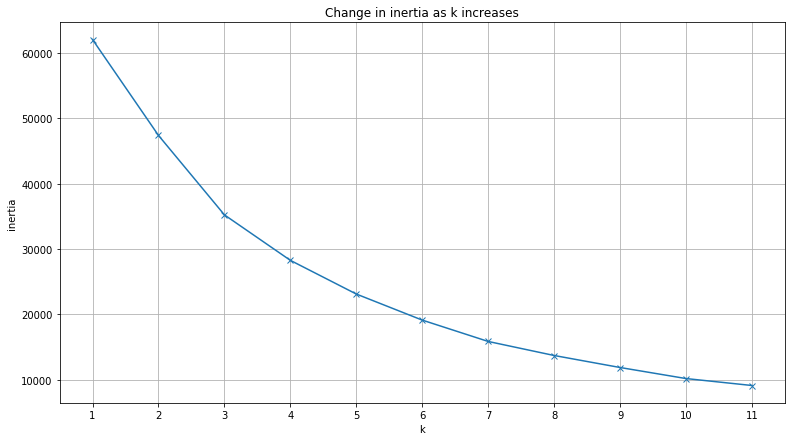

In [12]:
# Choosing optimal clusters by elbow method 

# Create a dictionary to hold the inertias
output = {}

# Iterate k from 1 to 11, calculate their inertias and store them in the dictionary 
for k in range(1, 12): 
    kmeans = KMeans(n_clusters=k, random_state=1)
    kmeans.fit(train_g2_scaled)
    output[k] = kmeans.inertia_

# Visualize the inertia against k
ax = pd.Series(output).plot(figsize=(13,7), marker='x')
ax.set(xlabel='k', ylabel='inertia', xticks=range(1,12), title='Change in inertia as k increases')
ax.grid()

In [13]:
# Based on the above visualization, I chose 6 as the number of clusters. 
# Convert the labels to dataframe named cluster2. 

kmeans2, cluster2 = model.kmeans_labels(train_g2_scaled, cols_to_cluster, 6)
cluster2.head()

,cluster
71142,0
11459,0
54330,0
46830,0
53521,0


In [14]:
# Join the labels with the train dataset

train = pd.concat([train, cluster2], axis=1)
train.rename(columns={'cluster': 'cluster2'}, inplace=True)
train.head()

,parcelid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedfinishedsquarefeet,finishedsquarefeet12,fullbathcnt,latitude,longitude,lotsizesquarefeet,...,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,logerror,error_type,fips_Orange,fips_Ventura,logtaxvaluedollarcnt,cluster2
71142,17052781,2.0,3.0,6.0,1164.0,1164.0,2.0,34450589.0,-119275390.0,6911.0,...,166435.0,436893.0,270458.0,5302.10,0.045179,1,0,1,5.640375,0
11459,11162056,3.0,4.0,7.0,2682.0,2682.0,3.0,34437293.0,-118382780.0,6048.0,...,307938.0,399176.0,91238.0,6231.12,0.000996,1,0,0,5.601164,0
54330,14033552,3.0,5.0,6.0,2194.0,2194.0,3.0,33723432.0,-117930813.0,6365.0,...,164767.0,379971.0,215204.0,4447.62,-0.012577,0,1,0,5.579750,0
46830,12918779,2.0,3.0,4.0,1586.0,1586.0,2.0,34096557.0,-117918930.0,6544.0,...,52013.0,82223.0,30210.0,1311.36,-0.029993,0,0,0,4.914993,0
53521,13993542,2.0,4.0,6.0,1619.0,1619.0,2.0,33826921.0,-117955128.0,6090.0,...,42755.0,64480.0,21725.0,1066.06,-0.038353,0,1,0,4.809425,0


Text(0.5, 1.0, 'Clustering zillow dataset by logerror and taxvaluedollarcnt')

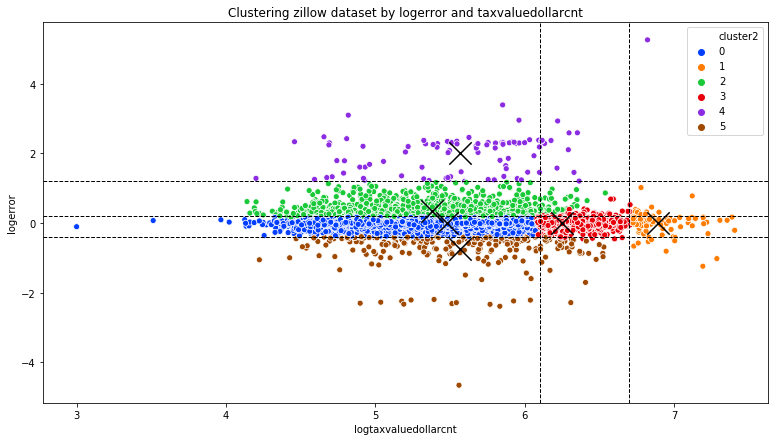

In [66]:
# Visualize the clusters along with their centers

# Set up the fiture size
plt.figure(figsize=(13,7))

# Scatterplot the clusters
ax = sns.scatterplot(data=train, x='logtaxvaluedollarcnt', y='logerror', hue='cluster2', palette='bright')

# Plot the dashed line to draw the boundaries of the clusters
plt.axhline(0.2, color='k', linestyle='dashed', linewidth=1)
plt.axhline(1.2, color='k', linestyle='dashed', linewidth=1)
plt.axhline(-0.4, color='k', linestyle='dashed', linewidth=1)
plt.axvline(6.1, color='k', linestyle='dashed', linewidth=1)
plt.axvline(6.7, color='k', linestyle='dashed', linewidth=1)

# Scatterplot the centers of the clusters
train.groupby('cluster2').mean().plot.scatter(y='logerror', x='logtaxvaluedollarcnt', 
                                              marker='x', s=500, ax=ax, c='black')
# Write the title
plt.title('Clustering zillow dataset by logerror and taxvaluedollarcnt')

# # Finally, the picture is saved as clustering_logerror.png for the purpose of presentation.

<div class="alert alert-block alert-info"><b>Takeaways:</b><br>
    1. The observations are grouped into 6 clusters.<br>
    2. Based on logtaxvaluedollarcnt, the observations are grouped into 3:<br>
        - Economic: values below about 1 million: cluster in purple, green, blue and brown<br>
        - Comfortable: between 1 and 5 million: cluster in red<br>
        - Luxury: values above 5 million: cluster in orange<br>
    3. Based on logerror, the observations could be grouped into 4:<br>
        - Low error: clusters in blue, red, and orange<br>
        - Medium positive error: cluster in green<br>
        - High positive error: cluster in purple<br>
        - Medium/high negative error: cluster in brown.</div>

> ## *Where are the medium or high logerror located?*
    > ### - *Do they form clusters on the map?* 

Text(0.5, 1.0, 'luxury')

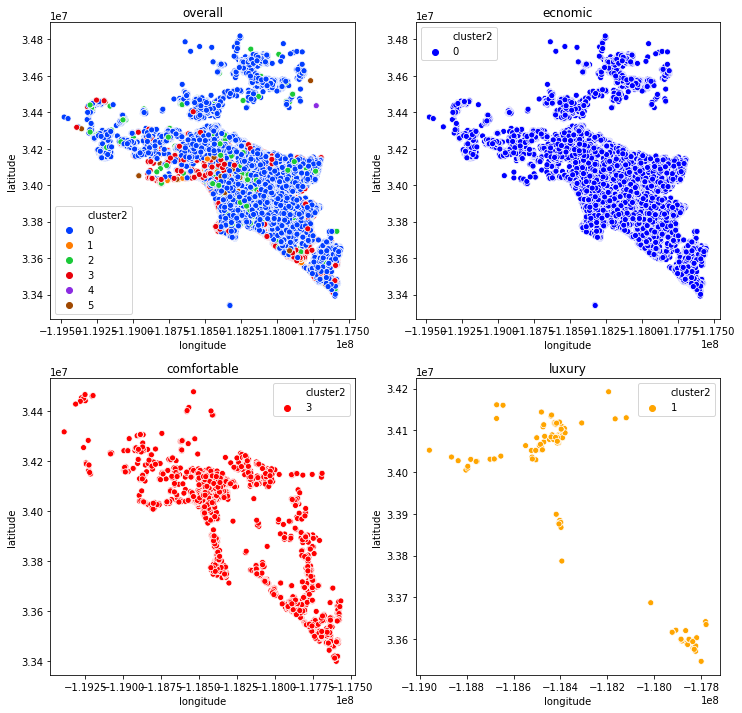

In [16]:
# Visualize the location (longitude and latitude) for all clusters, cluster number 0, 3, and 1. 

plt.figure(figsize=(12,12))

# Scatterplot all the clusters
plt.subplot(221)
sns.scatterplot(data=train, x='longitude', y='latitude', hue='cluster2', palette='bright')
plt.title('overall')

# Scatterplot cluster 0
plt.subplot(222)
sns.scatterplot(data=train[train.cluster2 == 0], 
                           x='longitude', y='latitude', hue='cluster2', palette=['blue'])
plt.title('ecnomic')

# Scatterplot cluster 3
plt.subplot(223)
sns.scatterplot(data=train[train.cluster2 == 3], 
                           x='longitude', y='latitude', hue='cluster2', palette=['red'])
plt.title('comfortable')

# Scatterplot cluster 1
plt.subplot(224)
sns.scatterplot(data=train[train.cluster2 == 1], 
                           x='longitude', y='latitude', hue='cluster2', palette=['orange'])
plt.title('luxury')

# Finally, the picture is saved as logerror_long_lat.png for the purpose of presentation.

<div class="alert alert-block alert-info"><b>Takeaways:</b><br>
    1. As the property value goes up, they gradually move towards the two ends of the three counties, creating a hollow in the LA county.<br> 
    2. Several luxury properties are clustered in the LA downtown.<br> 
    3. Such pattern is not uncommon.</div>

Text(0.5, 1.0, 'error type: medium/high negative')

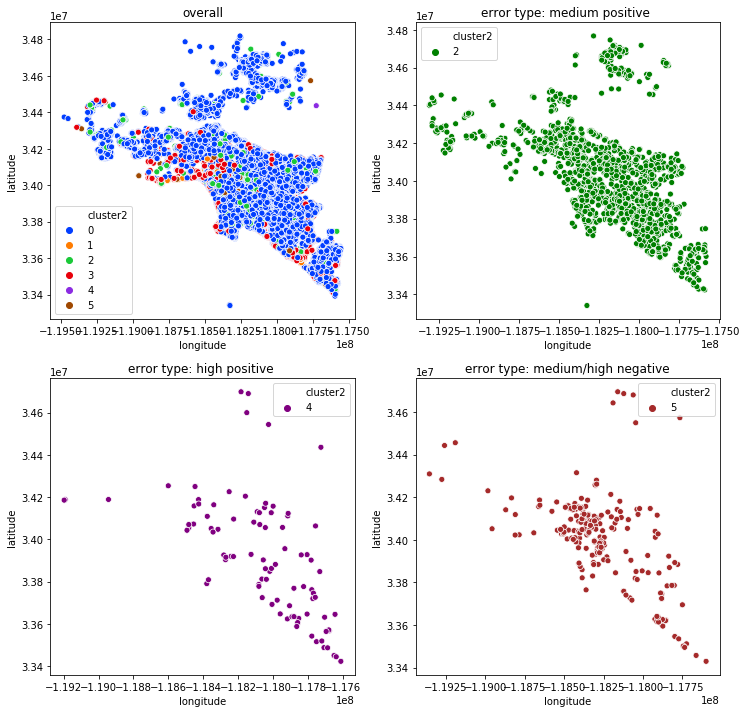

In [17]:
# Visualize the location (longitude and latitude) for all clusters, cluster number 2, 4, and 5. 

plt.figure(figsize=(12,12))

# Scatterplot all the clusters
plt.subplot(221)
sns.scatterplot(data=train, x='longitude', y='latitude', hue='cluster2', palette='bright')
plt.title('overall')

# Scatterplot cluster number 2
plt.subplot(222)
sns.scatterplot(data=train[train.cluster2 == 2], 
                           x='longitude', y='latitude', hue='cluster2', palette=['green'])
plt.title('error type: medium positive ')

# Scatterplot cluster number 4
plt.subplot(223)
sns.scatterplot(data=train[train.cluster2 == 4], 
                           x='longitude', y='latitude', hue='cluster2', palette=['purple'])
plt.title('error type: high positive ')

# Scatterplot cluster number 5
plt.subplot(224)
sns.scatterplot(data=train[train.cluster2 == 5], 
                           x='longitude', y='latitude', hue='cluster2', palette=['brown'])
plt.title('error type: medium/high negative')

# Finally, the picture is saved as logerror_long_lat.png for the purpose of presentation.

<div class="alert alert-block alert-info"><b>Takeaways:</b><br>
    1. The positive logerror, whether medium or high, has no specific clusters among three counties. They seems all over the place.<br>
    2. The meidum/high negative logerror has an obvious cluster in LA country.</div>

> ## *Conclusions:*
> ### *- The logerror is tends to increase as the property value drops.*
> ### *- The logerror can be clustered into 6 groups based on the property value and error range.*
> ### *- No specific clusters of medium/high positve logerror are found based on longitude and latitude.*
> ### *- Medium/high nagetive logerror has a obvious cluster in LA country.* 

> ## *Thanks for your attention.* 
> ## *This marks the end of the presentation. Below are modeling and model evalutions.*

<div class="alert alert-block alert-warning"><b>Please Read:<b><br>
    <b>Modeling Introduction<b><br>
        - I planned to model every cluster (total 6) in the optimal result generated by K-means.<br> 
        - Due to the limited time for the project (2 days), I am only able to modeling 1 clusters.<br>
        - The cluster I chose is the most frequenct one: the economic properties with low logerror.<br>
        - A new feature is created: error_type to indicate the sign of the logerror.<br>
        - The train/validate/test datasets are read from .csv produced in cluster_zillow.ipynb.</div>

In [18]:
# Review the relative frequency of the 6 clusters

train.cluster2.value_counts(normalize=True)

0    0.865057
3    0.070743
2    0.050116
5    0.007445
1    0.003642
4    0.002997
Name: cluster2, dtype: float64

### Scale train/validate/test for the economic properties with low logerror by standardscaler
- The reason why to choose the standardscaler is to keep the scaling method consistent within the same project.

In [19]:
# Load train/validate/test datasets from .csv for the purpose of modeling
# All the observations in .csv has been labeled.

train = pd.read_csv('train.csv', index_col=0)
validate = pd.read_csv('validate.csv', index_col=0)
test = pd.read_csv('test.csv', index_col=0)

# Create masks for the economic properties with low logerror

mask_tr = (train.cluster2 == 0)
mask_v = (validate.cluster2 == 0)
mask_t = (test.cluster2 == 0)

# Create train/validate/test for the economic properties with low logerror

train_0 = train[mask_tr]
validate_0 = validate[mask_v]
test_0 = test[mask_t]

# Create a variable to hold the numeric features need to be scaled (16 in total) 

columns_to_scale = ['bathroomcnt', 'bedroomcnt', 'buildingqualitytypeid',
                    'calculatedfinishedsquarefeet', 'finishedsquarefeet12', 'fullbathcnt',
                    'latitude', 'longitude', 'lotsizesquarefeet',
                    'roomcnt', 'yearbuilt', 'structuretaxvaluedollarcnt',
                    'taxvaluedollarcnt', 'landtaxvaluedollarcnt', 'taxamount',
                    'logtaxvaluedollarcnt']

# Scale train/validate/test for the economic properties with low logerror

scaler_0, train_scaled_0, validate_scaled_0, test_scaled_0 = prepare.scale_standard(train_0,
                                                                                    validate_0,
                                                                                    test_0,
                                                                                    columns_to_scale)
# Print out the scaler object and the shape of three datasets

scaler_0, train_scaled_0.shape, validate_scaled_0.shape, test_scaled_0.shape

(StandardScaler(copy=True, with_mean=True, with_std=True),
 (26841, 24),
 (11496, 22),
 (6798, 22))

### Visualize the clustering using the validate/test datasets

Text(0.5, 1.0, 'Clustering target variable logerror using validate dataset')

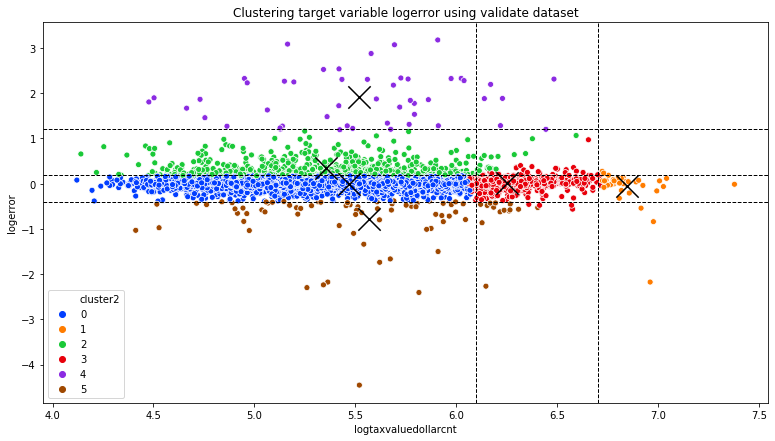

In [20]:
# Set up the fiture size
plt.figure(figsize=(13,7))

# Scatterplot the clusters using validate dataset
ax = sns.scatterplot(data=validate, x='logtaxvaluedollarcnt', y='logerror', hue='cluster2', palette='bright')

# Plot the dashed line to draw the boundaries of the clusters
plt.axhline(0.2, color='k', linestyle='dashed', linewidth=1)
plt.axhline(1.2, color='k', linestyle='dashed', linewidth=1)
plt.axhline(-0.4, color='k', linestyle='dashed', linewidth=1)
plt.axvline(6.1, color='k', linestyle='dashed', linewidth=1)
plt.axvline(6.7, color='k', linestyle='dashed', linewidth=1)

# Scatterplot the centers of the clusters
validate.groupby('cluster2').mean().plot.scatter(y='logerror', x='logtaxvaluedollarcnt',
                                                 marker='x', s=500, ax=ax, c='black')
# Write the title
plt.title('Clustering target variable logerror using validate dataset')

Text(0.5, 1.0, 'Clustering target variable logerror using test dataset')

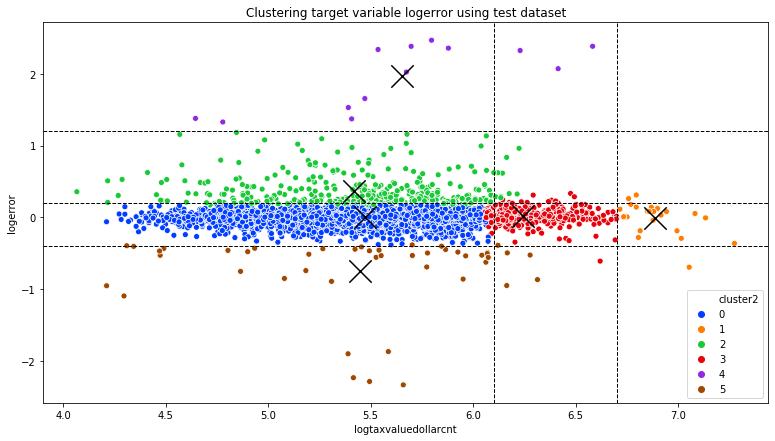

In [21]:
# Set up the fiture size
plt.figure(figsize=(13,7))

# Scatterplot the clusters using test dataset
ax = sns.scatterplot(data=test, x='logtaxvaluedollarcnt', y='logerror', hue='cluster2', palette='bright')

# Plot the dashed line to draw the boundaries of the clusters
plt.axhline(0.2, color='k', linestyle='dashed', linewidth=1)
plt.axhline(1.2, color='k', linestyle='dashed', linewidth=1)
plt.axhline(-0.4, color='k', linestyle='dashed', linewidth=1)
plt.axvline(6.1, color='k', linestyle='dashed', linewidth=1)
plt.axvline(6.7, color='k', linestyle='dashed', linewidth=1)

# Scatterplot the centers of the clusters
test.groupby('cluster2').mean().plot.scatter(y='logerror', x='logtaxvaluedollarcnt', 
                                             marker='x', s=500, ax=ax, c='black')
# Write the title
plt.title('Clustering target variable logerror using test dataset')

<div class="alert alert-block alert-info"><b>Takeaways:</b><br>
    1. The validate and test dataset are clustered into 6 groups, similar to the training dataset.<br>
    2. No overfitting is observed through visualization.</div>

### Feature Engineering on training dataset
- Top 10 features are selected out of 19 in total

In [22]:
# Show all the columns in training dataset, 19 in total

predictors=['error_type', 'fips_Orange', 'fips_Ventura',
            'bathroomcnt_scaled', 'bedroomcnt_scaled', 'buildingqualitytypeid_scaled',
            'calculatedfinishedsquarefeet_scaled', 'finishedsquarefeet12_scaled',
            'fullbathcnt_scaled', 'latitude_scaled', 'longitude_scaled',
            'lotsizesquarefeet_scaled', 'roomcnt_scaled', 'yearbuilt_scaled',
            'structuretaxvaluedollarcnt_scaled', 'taxvaluedollarcnt_scaled',
            'landtaxvaluedollarcnt_scaled', 'taxamount_scaled','logtaxvaluedollarcnt_scaled']

In [23]:
# Create X and y for train/validate/test

X_train_scaled = train_scaled_0[predictors]
y_train = train_scaled_0['logerror']

X_validate_scaled = validate_scaled_0[predictors]
y_validate = validate_scaled_0['logerror']

X_test_scaled = test_scaled_0[predictors]
y_test = test_scaled_0['logerror']

# Print out shape of the X_train/validate/test_scaled

X_train_scaled.shape, X_validate_scaled.shape, X_test_scaled.shape

((26841, 19), (11496, 19), (6798, 19))

### Select top 10 features by select KBset f-regression

In [24]:
# Call function to select top 10 features by select KBest

f_features = features.select_kbest(X_train_scaled, y_train, 10)

# Print out top 10 features
f_features

['error_type',
 'fips_Orange',
 'bathroomcnt_scaled',
 'bedroomcnt_scaled',
 'calculatedfinishedsquarefeet_scaled',
 'finishedsquarefeet12_scaled',
 'fullbathcnt_scaled',
 'roomcnt_scaled',
 'yearbuilt_scaled',
 'structuretaxvaluedollarcnt_scaled']

### Select top 10 features by Recursive Feature Elimination

In [25]:
# Call function to select top 10 features by rfe

rfe_features = features.rfe(X_train_scaled, y_train, 10)

# Print out rfe_features

rfe_features

['error_type',
 'fips_Ventura',
 'calculatedfinishedsquarefeet_scaled',
 'finishedsquarefeet12_scaled',
 'latitude_scaled',
 'yearbuilt_scaled',
 'structuretaxvaluedollarcnt_scaled',
 'taxvaluedollarcnt_scaled',
 'landtaxvaluedollarcnt_scaled',
 'logtaxvaluedollarcnt_scaled']

<div class="alert alert-block alert-info"><b>Takeaways:</b><br>
    1. Error_type is the #1 chosen by both f-regression and RFE.<br>
    2. fip_ related features are selected as #2 by both. However, the county is different.<br>
    3. Afterwards, f-regession chose bath/bedrooms while RFE chose square feet and RFE doesn't inlcude the bath/bedrooms at all.<br>
    4. Then f-regression chose the square feet while rfe chose latitude.<br>
    5. Both include yearbuit and taxvaluedollarcnt in different formats.</div> 

### Set up baseline

In [26]:
# Compute baseline mean and median

mean, median = y_train.agg(['mean', 'median'])
mean, median

# mean is close to zero and is used as the predcited value for all observations

(-0.001017732257761061, 0.00356437501802)

In [27]:
# Create the basedline predicted values

baseline = np.array([mean]*y_train.size)

# View first 5 basedline predicted values
baseline[:5]

array([-0.00101773, -0.00101773, -0.00101773, -0.00101773, -0.00101773])

In [28]:
# Compute baseline sse

baseline_residual = y_train - mean
baseline_sse = (baseline_residual**2).sum()
baseline_sse

114.3084721899935

In [29]:
# Compute baseline mse

baseline_mse = baseline_sse/y_train.size
baseline_mse

0.004258726284042826

In [30]:
# Compute baseline rmse

baseline_rmse = mean_squared_error(y_train, baseline)**1/2
baseline_rmse

0.002129363142021413

### Model train on f_features and rfe_features by three algorithms
- LinearRegression
- LassoLars
- Poly(2nd degree)

In [31]:
# Create X_train_scaled for f_features and rfe_features

X_train_scaled_f = X_train_scaled[f_features]
X_train_scaled_rfe = X_train_scaled[rfe_features]

# Create X_validate_scaled for f_features and rfe_features

X_validate_scaled_f = X_validate_scaled[f_features]
X_validate_scaled_rfe = X_validate_scaled[rfe_features]

# Create X_test_scaled for f_features and rfe_features

X_test_scaled_f = X_test_scaled[f_features]
X_test_scaled_rfe = X_test_scaled[rfe_features]

In [32]:
# Confirm the f_freatures in the X_train_scaled_f

X_train_scaled_f.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26841 entries, 17052781 to 14530930
Data columns (total 10 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   error_type                           26841 non-null  int64  
 1   fips_Orange                          26841 non-null  int64  
 2   bathroomcnt_scaled                   26841 non-null  float64
 3   bedroomcnt_scaled                    26841 non-null  float64
 4   calculatedfinishedsquarefeet_scaled  26841 non-null  float64
 5   finishedsquarefeet12_scaled          26841 non-null  float64
 6   fullbathcnt_scaled                   26841 non-null  float64
 7   roomcnt_scaled                       26841 non-null  float64
 8   yearbuilt_scaled                     26841 non-null  float64
 9   structuretaxvaluedollarcnt_scaled    26841 non-null  float64
dtypes: float64(8), int64(2)
memory usage: 2.3 MB


In [33]:
# Confirm the rfe_freatures in the X_train_scaled_rfe

X_train_scaled_rfe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26841 entries, 17052781 to 14530930
Data columns (total 10 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   error_type                           26841 non-null  int64  
 1   fips_Ventura                         26841 non-null  int64  
 2   calculatedfinishedsquarefeet_scaled  26841 non-null  float64
 3   finishedsquarefeet12_scaled          26841 non-null  float64
 4   latitude_scaled                      26841 non-null  float64
 5   yearbuilt_scaled                     26841 non-null  float64
 6   structuretaxvaluedollarcnt_scaled    26841 non-null  float64
 7   taxvaluedollarcnt_scaled             26841 non-null  float64
 8   landtaxvaluedollarcnt_scaled         26841 non-null  float64
 9   logtaxvaluedollarcnt_scaled          26841 non-null  float64
dtypes: float64(8), int64(2)
memory usage: 2.3 MB


### Ordinary Least Squares using LinearRegression

In [34]:
# Create and print lm object

lm = LinearRegression(normalize=True)
lm

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [35]:
# Fit train dataset with f_features

lm_f = lm.fit(X_train_scaled_f, y_train)

# Predict the logerror
lm_pred_f = lm_f.predict(X_train_scaled_f)

# Calculate the RMSE
lm_rmse_f = mean_squared_error(y_train, lm_pred_f)**1/2

# Print lm_f object and RMSE

lm_f, lm_rmse_f

(LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True),
 0.0011336665326328493)

In [36]:
# Fit train dataset with rfe_features

lm_rfe = lm.fit(X_train_scaled_rfe, y_train)

# Predict the logerror
lm_pred_rfe = lm_rfe.predict(X_train_scaled_rfe)

# Calculate the RMSE
lm_rmse_rfe = mean_squared_error(y_train, lm_pred_rfe)**1/2

# Print lm_rfe object and RMSE

lm_rfe, lm_rmse_rfe

(LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True),
 0.001132952487290195)

<div class="alert alert-block alert-info"><b>Takeaways:</b><br>
    1. The two lm models are evaluated by comparing RMSE to baseline. <br>
    2. Both lm models performs much better than baseline.<br>
    3. There is no significant difference between the two lm models.</div>

### LassoLars()

In [37]:
# Create and print lars object (alpha=0.1)

lars = LassoLars(alpha=0.1)
lars

LassoLars(alpha=0.1, copy_X=True, eps=2.220446049250313e-16, fit_intercept=True,
          fit_path=True, max_iter=500, normalize=True, positive=False,
          precompute='auto', verbose=False)

In [38]:
# Fit train dataset with f_features
lars_f = lars.fit(X_train_scaled_f, y_train)

# Predict the logerror
lars_pred_f = lars_f.predict(X_train_scaled_f)

# Calculate the RMSE
lars_rmse_f = mean_squared_error(y_train, lars_pred_f)**1/2

# Print lars_f object and RMSE
lars_f, lars_rmse_f

(LassoLars(alpha=0.1, copy_X=True, eps=2.220446049250313e-16, fit_intercept=True,
           fit_path=True, max_iter=500, normalize=True, positive=False,
           precompute='auto', verbose=False),
 0.002129363142021413)

In [39]:
# Fit train dataset with rfe_features
lars_rfe = lars.fit(X_train_scaled_rfe, y_train)

# Predict the logerror
lars_pred_rfe = lars_rfe.predict(X_train_scaled_rfe)

# Calculate the RMSE
lars_rmse_rfe = mean_squared_error(y_train, lars_pred_rfe)**1/2

# Print lars_rfe object and RMSE
lars_rfe, lars_rmse_rfe

(LassoLars(alpha=0.1, copy_X=True, eps=2.220446049250313e-16, fit_intercept=True,
           fit_path=True, max_iter=500, normalize=True, positive=False,
           precompute='auto', verbose=False),
 0.002129363142021413)

<div class="alert alert-block alert-info"><b>Takeaways:</b><br>
    1. The two lars models are evaluated by comparing RMSE to baseline. <br>
    1. There is no significant difference between the two lars models and baseline.</div>

### PolynomialFeatures + LinearRegression (degree = 2)

In [40]:
# Make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2)

# Fit and transform X_train_scaled
X_train_scaled_squared_f = pf.fit_transform(X_train_scaled_f)
X_train_scaled_squared_rfe = pf.fit_transform(X_train_scaled_rfe)

# Transform X_validate_scaled
X_validate_scaled_squared_f = pf.transform(X_validate_scaled_f)
X_validate_scaled_squared_rfe = pf.transform(X_validate_scaled_rfe)

# Transform X_test_scaled
X_test_scaled_squared_f = pf.transform(X_test_scaled_f)
X_test_scaled_squared_rfe = pf.transform(X_test_scaled_rfe)

In [41]:
# Create the model object

lm2 = LinearRegression(normalize=True)

In [42]:
# Fit the model to the training data with f_features 
lm_squared_f = lm2.fit(X_train_scaled_squared_f, y_train)

# Predict train
lm_squared_pred_f = lm_squared_f.predict(X_train_scaled_squared_f)

# Compute RMSE
lm_squared_rmse_f = mean_squared_error(y_train, lm_squared_pred_f)**1/2

# Print model object and RMSE
lm_squared_f, lm_squared_rmse_f

(LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True),
 0.001080349239276396)

In [43]:
# Fit the model to the training data with rfe_features
lm_squared_rfe = lm2.fit(X_train_scaled_squared_rfe, y_train)

# Predict train
lm_squared_pred_rfe = lm_squared_rfe.predict(X_train_scaled_squared_rfe)

# Compute RMSE
lm_squared_rmse_rfe = mean_squared_error(y_train, lm_squared_pred_rfe)**1/2

# Print model object and RMSE
lm_squared_rfe, lm_squared_rmse_rfe

(LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True),
 0.0010776650622783437)

<div class="alert alert-block alert-info"><b>Takeaways:</b><br>
    1. The two poly models are evaluated by comparing RMSE to baseline. <br>
    2. Both poly models performs much better than baseline.<br>
    3. There is no significant difference between the two poly models.</div>

In [44]:
# Summarize the RMSE of all 6 models above

# Create a list to hold all 6 RMSE values

rmse_values = [baseline_rmse,
               lm_rmse_f, lm_rmse_rfe, 
               lars_rmse_f, lars_rmse_rfe, 
               lm_squared_rmse_f, lm_squared_rmse_rfe]

# Create a list to hold the names of the 6 RMSE values

rmse_index = ['baseline_rmse',
              'lm_rmse_f', 'lm_rmse_rfe',
              'lars_rmse_f', 'lars_rmse_rfe',
              'lm_squared_rmse_f', 'lm_squared_rmse_rfe']

# Organize the 6 RMSE values into a dataframe
rmse_train = pd.DataFrame(rmse_values, index=rmse_index, columns=['train_RMSE'])

# Sort the RMSE in ascending order
rmse_train.sort_values(by='train_RMSE')

,train_RMSE
lm_squared_rmse_rfe,0.001078
lm_squared_rmse_f,0.001080
lm_rmse_rfe,0.001133
lm_rmse_f,0.001134
baseline_rmse,0.002129
lars_rmse_f,0.002129
lars_rmse_rfe,0.002129


<div class="alert alert-block alert-info"><b>Takeaways:</b><br>
    Top 3 models are further used on validate datasets.</div>

### Model validate data on top 3 models
- PolynomialFeatures(degree=2) + LinearRegression + rfe features
- PolynomialFeatures(degree=2) + LinearRegression + f features
- LinearRegression + rfe features

### PolynomialFeatures(degree=2) + LinearRegression
- rfe features
- f features

In [45]:
# Predict validate with rfe features
lm_squared_pred_rfe = lm_squared_rfe.predict(X_validate_scaled_squared_rfe)

# Compute RMSE
lm_squared_rmse_rfe = mean_squared_error(y_validate, lm_squared_pred_rfe)**1/2

# Print out RMSE
lm_squared_rmse_rfe

7.152613243249004e+16

In [46]:
# Predict validate with f features
lm_squared_pred_f = lm_squared_f.predict(X_validate_scaled_squared_f)

# Compute RMSE
lm_squared_rmse_f = mean_squared_error(y_validate, lm_squared_pred_f)**1/2

# Print out RMSE
lm_squared_rmse_f

2.2274309337281536e+21

### OLS using LinearRegression on rfe features

In [47]:
# Predict validate with rfe features
lm_pred = lm_rfe.predict(X_validate_scaled_rfe)

# Compute model RMSE
lm_rmse_rfe = mean_squared_error(y_validate, lm_pred)**1/2

# Print out model RMSE
lm_rmse_rfe

0.0011274209116698846

In [48]:
# Summarize the RMSE of all 3 models above

# Create a list to hold all 3 RMSE values
rmse_values = [baseline_rmse,
               lm_squared_rmse_f, lm_squared_rmse_rfe,
               lm_rmse_rfe]

# Create a list of 3 RMSE names
rmse_index = ['baseline_rmse',
              'lm_squared_rmse_f', 'lm_squared_rmse_rfe',
              'lm_rmse_rfe']

# Organize the 3 RMSE values into a dataframe
rmse_validate = pd.DataFrame(rmse_values, index=rmse_index, columns=['validate_RMSE'])

# Sort the RMSE in ascending order
rmse_validate.sort_values(by='validate_RMSE')

,validate_RMSE
lm_rmse_rfe,1.127421e-03
baseline_rmse,2.129363e-03
lm_squared_rmse_rfe,7.152613e+16
lm_squared_rmse_f,2.227431e+21


<div class="alert alert-block alert-info"><b>Takeaways:</b><br>
    1. The best model is LinearRegression with rfe features.<br>
    2. The RMSE of the two poly models are huge, which indicates severe overfitting.<br>
    3. The best model is used on test dataset.</div> 

### Model selected on test dataset: LinearRegression + rfe features

In [49]:
# Predict on test
lm_pred = lm_rfe.predict(X_test_scaled_rfe)

# Compute model RMSE
lm_rmse_rfe = mean_squared_error(y_test, lm_pred)**1/2

# Print model RMSE
lm_rmse_rfe

0.0011525892150903837

In [50]:
# Create a dataframe to compare model's RMSE to baseline

rmse_values = [baseline_rmse,lm_rmse_rfe]
rmse_index = ['baseline_rmse','lm_rmse_rfe']

rmse_test = pd.DataFrame(rmse_values, index=rmse_index, columns=['test_RMSE'])
rmse_test.sort_values(by='test_RMSE')

,test_RMSE
lm_rmse_rfe,0.001153
baseline_rmse,0.002129


In [51]:
# Concat the three train/validate/test RMSE dataframes together

rmse_overall = pd.concat([rmse_train, rmse_validate], axis=1)
rmse_overall = pd.concat([rmse_overall, rmse_test], axis=1)

# Sort the datafrem by train_RMSE in ascending order
rmse_overall.sort_values(by='train_RMSE')

,train_RMSE,validate_RMSE,test_RMSE
lm_squared_rmse_rfe,0.001078,7.152613e+16,NaN
lm_squared_rmse_f,0.001080,2.227431e+21,NaN
lm_rmse_rfe,0.001133,1.127421e-03,0.001153
lm_rmse_f,0.001134,NaN,NaN
baseline_rmse,0.002129,2.129363e-03,0.002129
lars_rmse_f,0.002129,NaN,NaN
lars_rmse_rfe,0.002129,NaN,NaN


<div class="alert alert-block alert-info"><b>Takeaways:</b><br>
    1. The best model is LinearRegression with rfe features.<br>
    2. The best model has no overfitting issue.<br>
    3. The best model beats the basline by reducing 50% of the RMSE.</div> 

### Explore the drivers behind the best and worst model
- Best model: LinearRegression with rfe features
- Worse model: PolynomialFeatures(degree=2) with f features

### Plotting the acural vs. predicted in the best model

Text(0.5, 1.0, 'Distribution of predicted logerror by the best model')

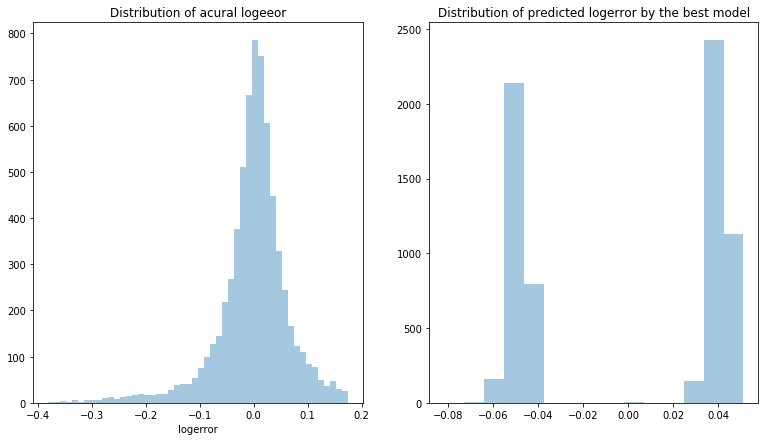

In [52]:
# Set up the figure size
plt.figure(figsize=(13,7))

# Plot the distribution of the acural logerror
plt.subplot(121)
sns.distplot(y_test, kde=False)
plt.title('Distribution of acural logeeor')

# Plot the distribution of the predicted logerror by the best model
plt.subplot(122)
sns.distplot(pd.Series(lm_pred), kde=False)
plt.title('Distribution of predicted logerror by the best model')

<div class="alert alert-block alert-info"><b>Takeaways:</b><br>
    1. As expected, the distrbution of the actural logerror is close to normal.<br>
    2. The predicted logerror has two separate distributions: one is below 0 and one is above 0.<br>
    3. Why are two distinct distrubtion found in the best model? </div> 

### Residual plot for the best model: plotting the errors in predictions

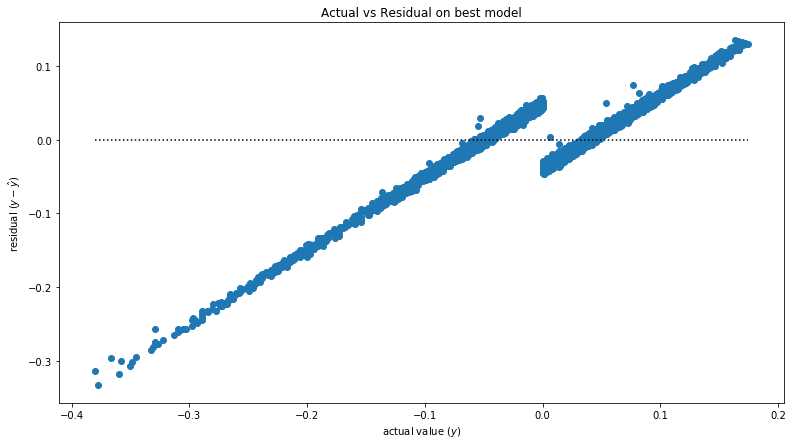

In [56]:
# Set up the figure size
plt.figure(figsize=(13,7))

# Call function to plot the residual against actural logerror
model.plot_residuals(y_test, pd.Series(lm_pred).values, 'best model')

<div class="alert alert-block alert-info"><b>Takeaways:</b><br>
    1. To my surprise, two parallel lines are observed, rather than a single line.<br>
    2. The two lines should match the two distinct distriution in the distribution plot.<br>
    3. Two paralle lines provide extra flexibility than the single line, which is the main reason why LinearRegression with rfe features is the best model.<br>
    5. I propose that it is resulted from the top feature 'error_type': one line is used to predict the logerror that is larger than 0; the other line is used to predict the logerror that is less than 0.</div>

### Plotting the acural vs. predicted in the worst model

Text(0.5, 1.0, 'Distribution of predicted y by the worst model')

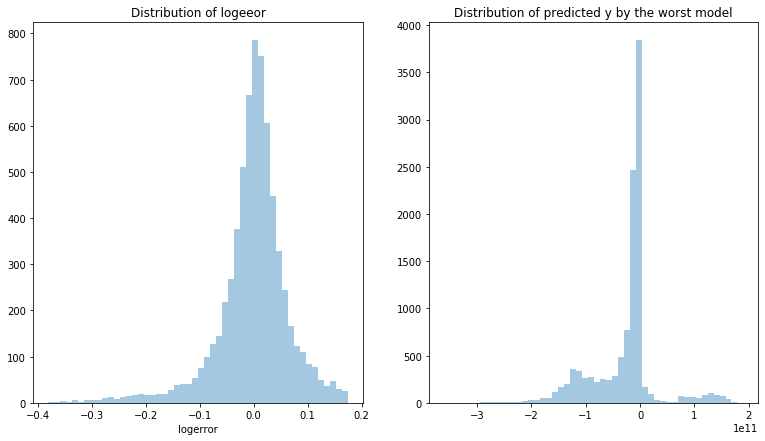

In [55]:
# Set up the figure size
plt.figure(figsize=(13,7))

# Plot the distribution of the actural logerror
plt.subplot(121)
sns.distplot(y_test, kde=False)
plt.title('Distribution of actural logeeor')

# Plot the distribution of the precicted logerror by the worst model
plt.subplot(122)
sns.distplot(pd.Series(lm_squared_pred_f), kde=False)
plt.title('Distribution of predicted y by the worst model')

In [59]:
lm_squared_pred_f

array([-2.15851280e+08, -3.52865344e+09, -4.38156385e+08, ...,
       -6.97449961e+10, -1.13981436e+11, -8.19706037e+09])

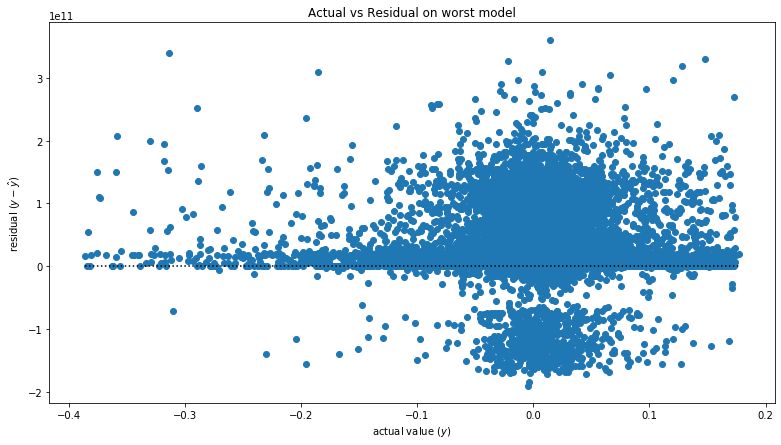

In [64]:
# Set up the figure size
plt.figure(figsize=(13,7))

# Call function to plot the residual against actural logerror by the worst model
model.plot_residuals(y_validate, pd.Series(lm_squared_pred_f).values, 'worst model')

<div class="alert alert-block alert-info"><b>Takeaways:</b><br>
    1. Surprisingly,the worst model performs the worst when logerror is around zero, which is opposite to where I was assuming most of the inaccuracy would come from.<br>
    2. The scale of the residual is really high. The maximum residual is 10 times higher than the best model.</div>

<div class="alert alert-block alert-success"><b>Summary of Key Findings:</b><br>
    1. The biggest driver of the logerror is taxvlauedollarcnt.<br>
    2. The zillow dataset can be clustered into 6 distinct groups based on logerror and property value.<br>
    3. Medium/high nagetive logerror has an obvious cluster in LA country.<br>
    4. No specific clusters of medium/high positve logerror are found based on location.<br> 
    5. The top model is the LinearRegression with rfe features and it beats the baseline by redcuing 50% of te RMSE.<br> 
    6. A new created categorical feature 'error_type' plays an crucial role in improving the model performance and keep the model from being overfit.</div>